<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Генеративные модели в машинном обучении, МОВС, ФКН ВШЭ</center></h1>
<h2><center>Домашнее задание 3: Диффузия, потоки</center></h2>

# Введение

До заголовка "Диффузионные модели" все по-старому. Только Задания 1-2 теперь неоцениваемые, ведь вы их уже делали

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

    Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение.

    По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

    Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.

    Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [5]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("/kaggle/input/hw3-dataset/2024/homeworks/hw3/data/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [6]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [32]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [8]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [9]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [10]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

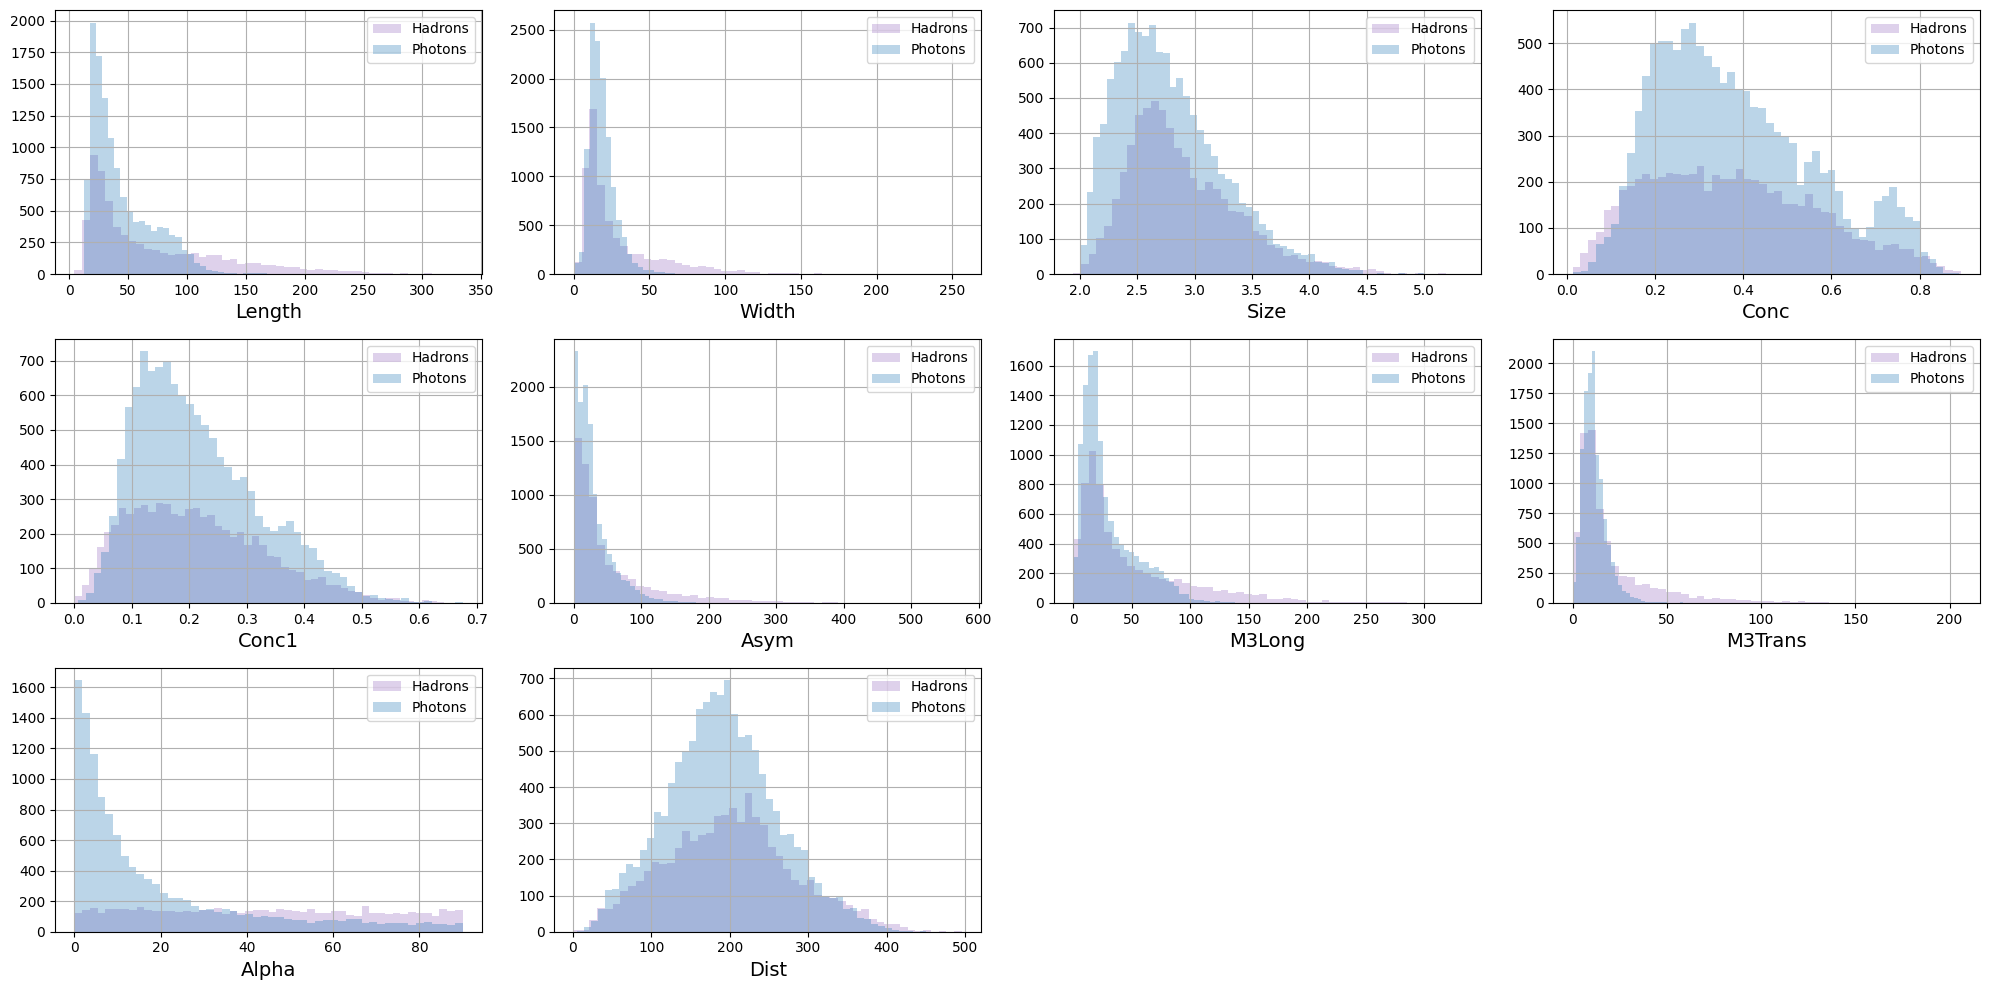

In [11]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [12]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size=0.5, shuffle = True, random_state = 11
)

## Задание 1 (0 баллов)

Проиллюстрируйте распределение y внутри train и test выборки.

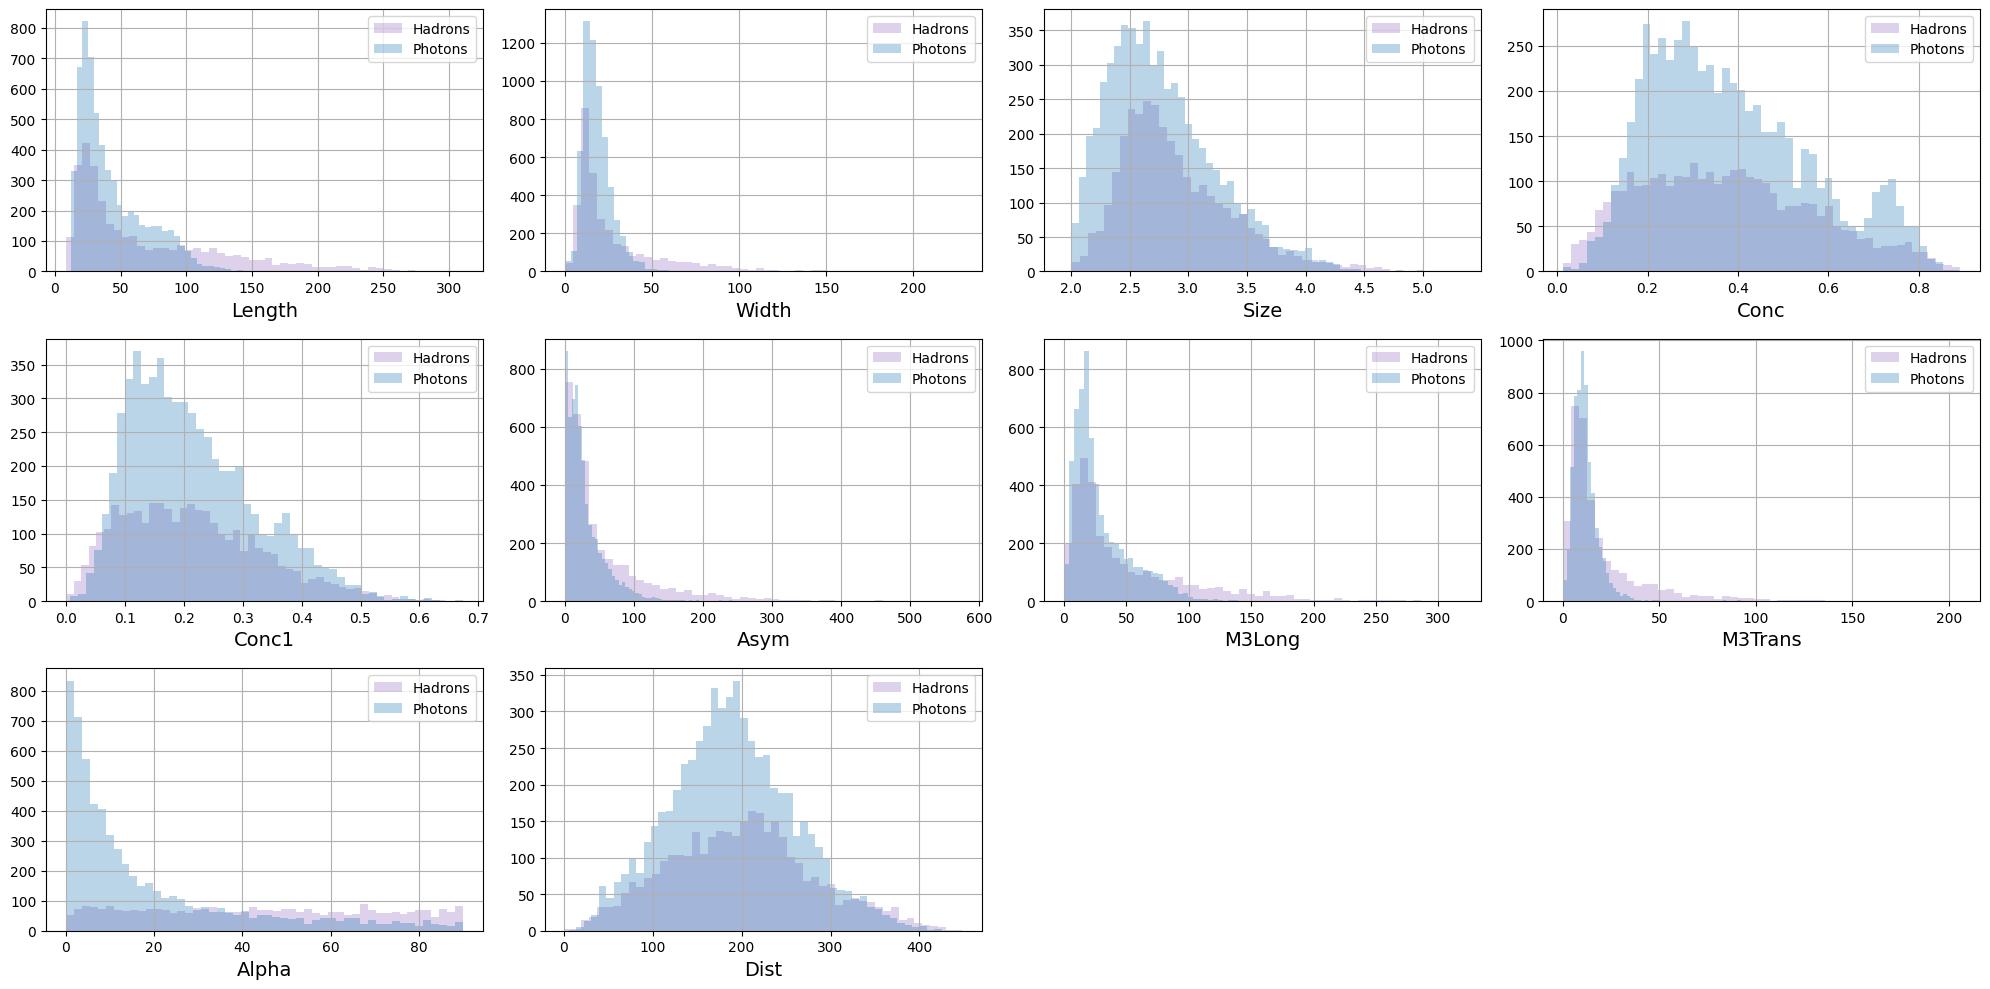

In [13]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)


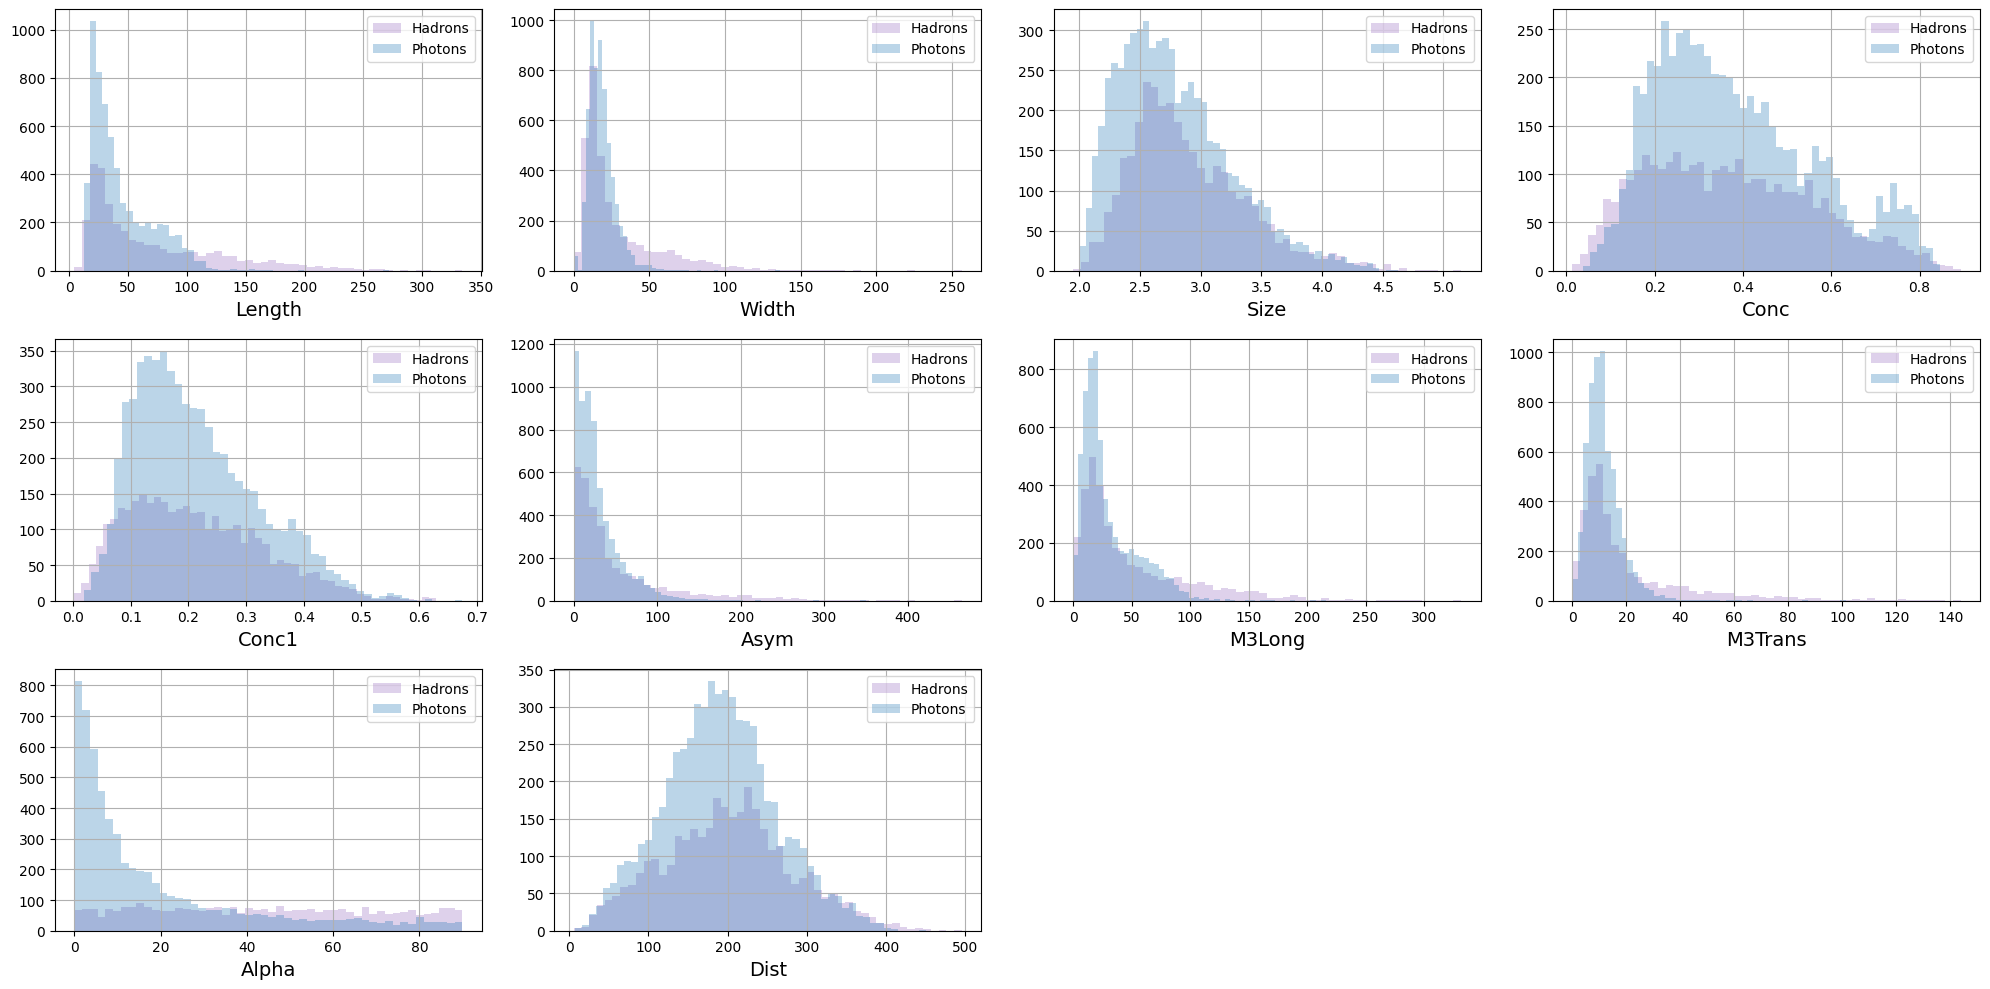

In [14]:
plot_hists(
    X_test[y_test[:, 0] == 0],
    X_test[y_test[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)


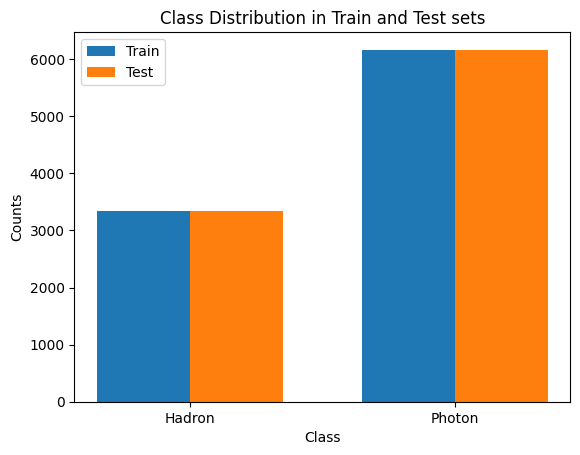

In [33]:
import matplotlib.pyplot as plt

train_counts = np.unique(y_train, return_counts=True)
test_counts = np.unique(y_test, return_counts=True)

labels = ['Hadron', 'Photon']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_counts[1], width, label='Train')
rects2 = ax.bar(x + width/2, test_counts[1], width, label='Test')

ax.set_xlabel('Class')
ax.set_ylabel('Counts')
ax.set_title('Class Distribution in Train and Test sets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


## Задание 2 (0 баллов)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [ ]:
### YOUR CODE IS HERE ######
X_train = ...
X_test = ...
### THE END OF YOUR CODE ###

In [18]:
from sklearn.preprocessing import QuantileTransformer

transformer = QuantileTransformer(output_distribution='normal', random_state=0)
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

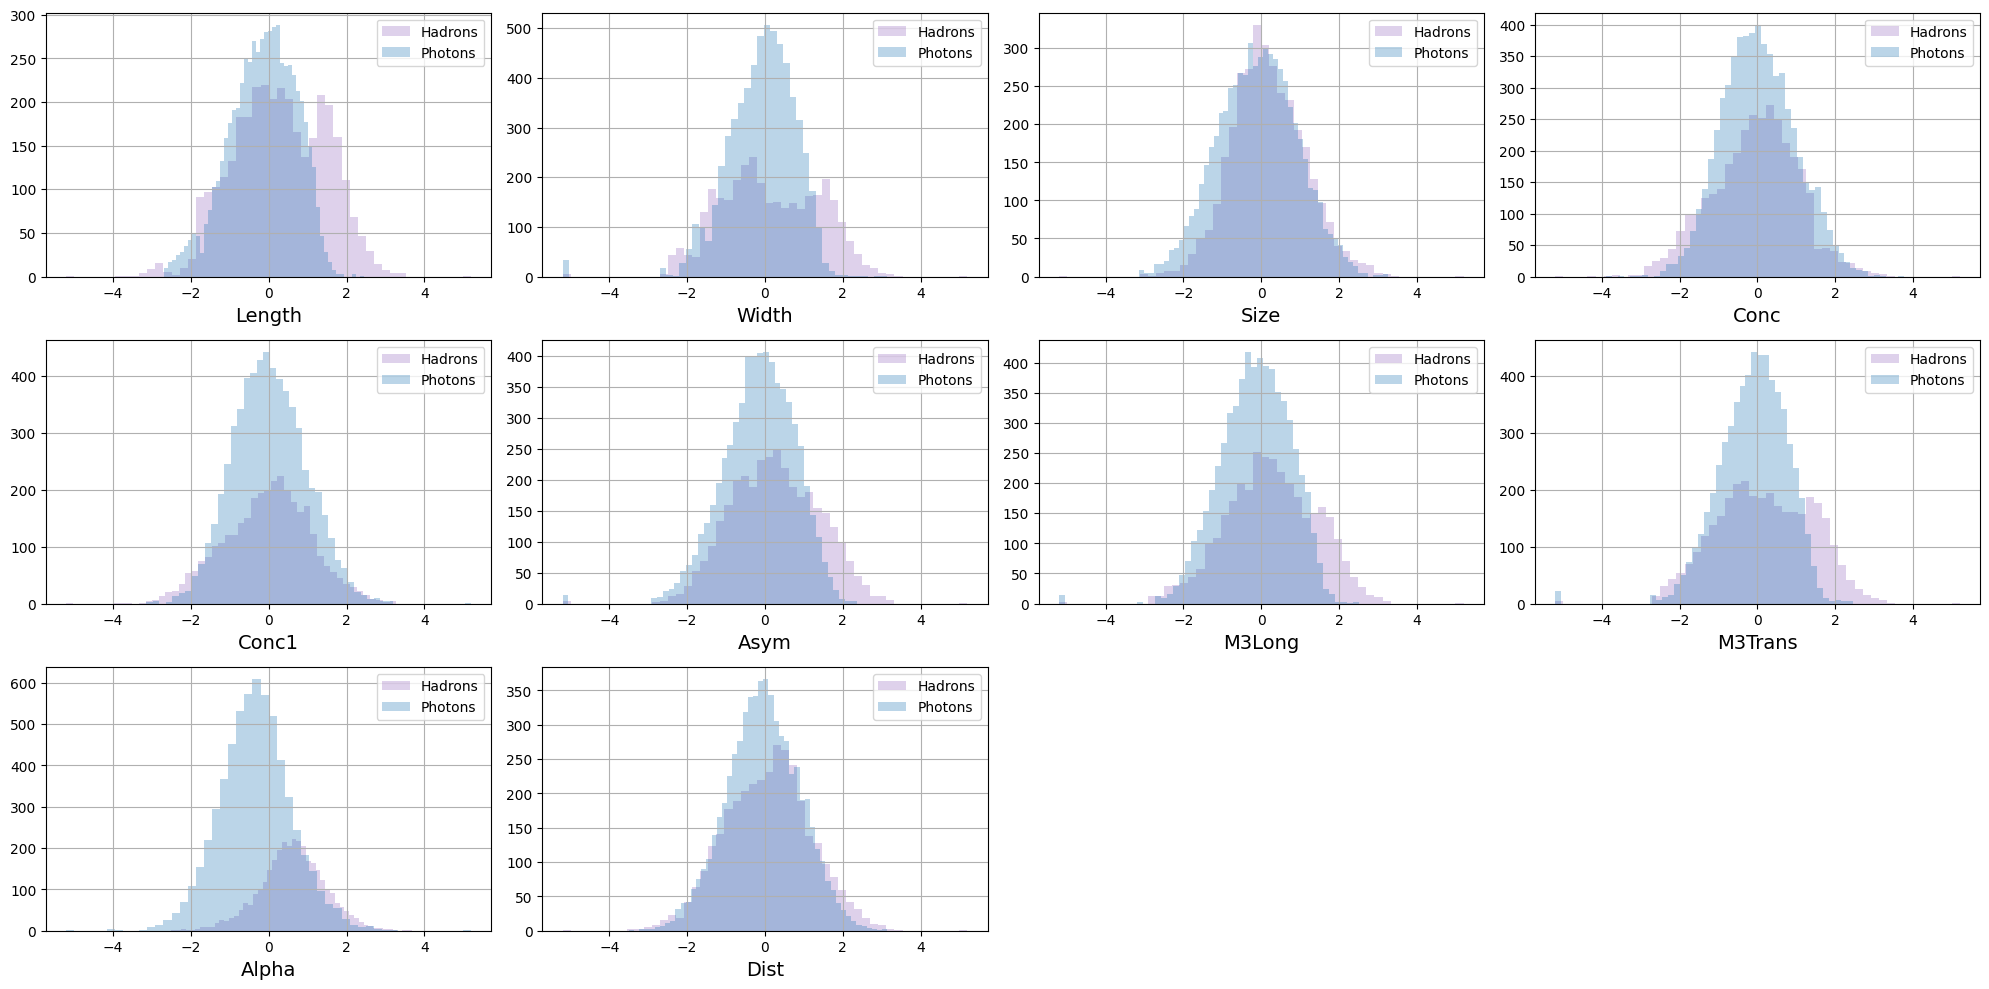

In [19]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

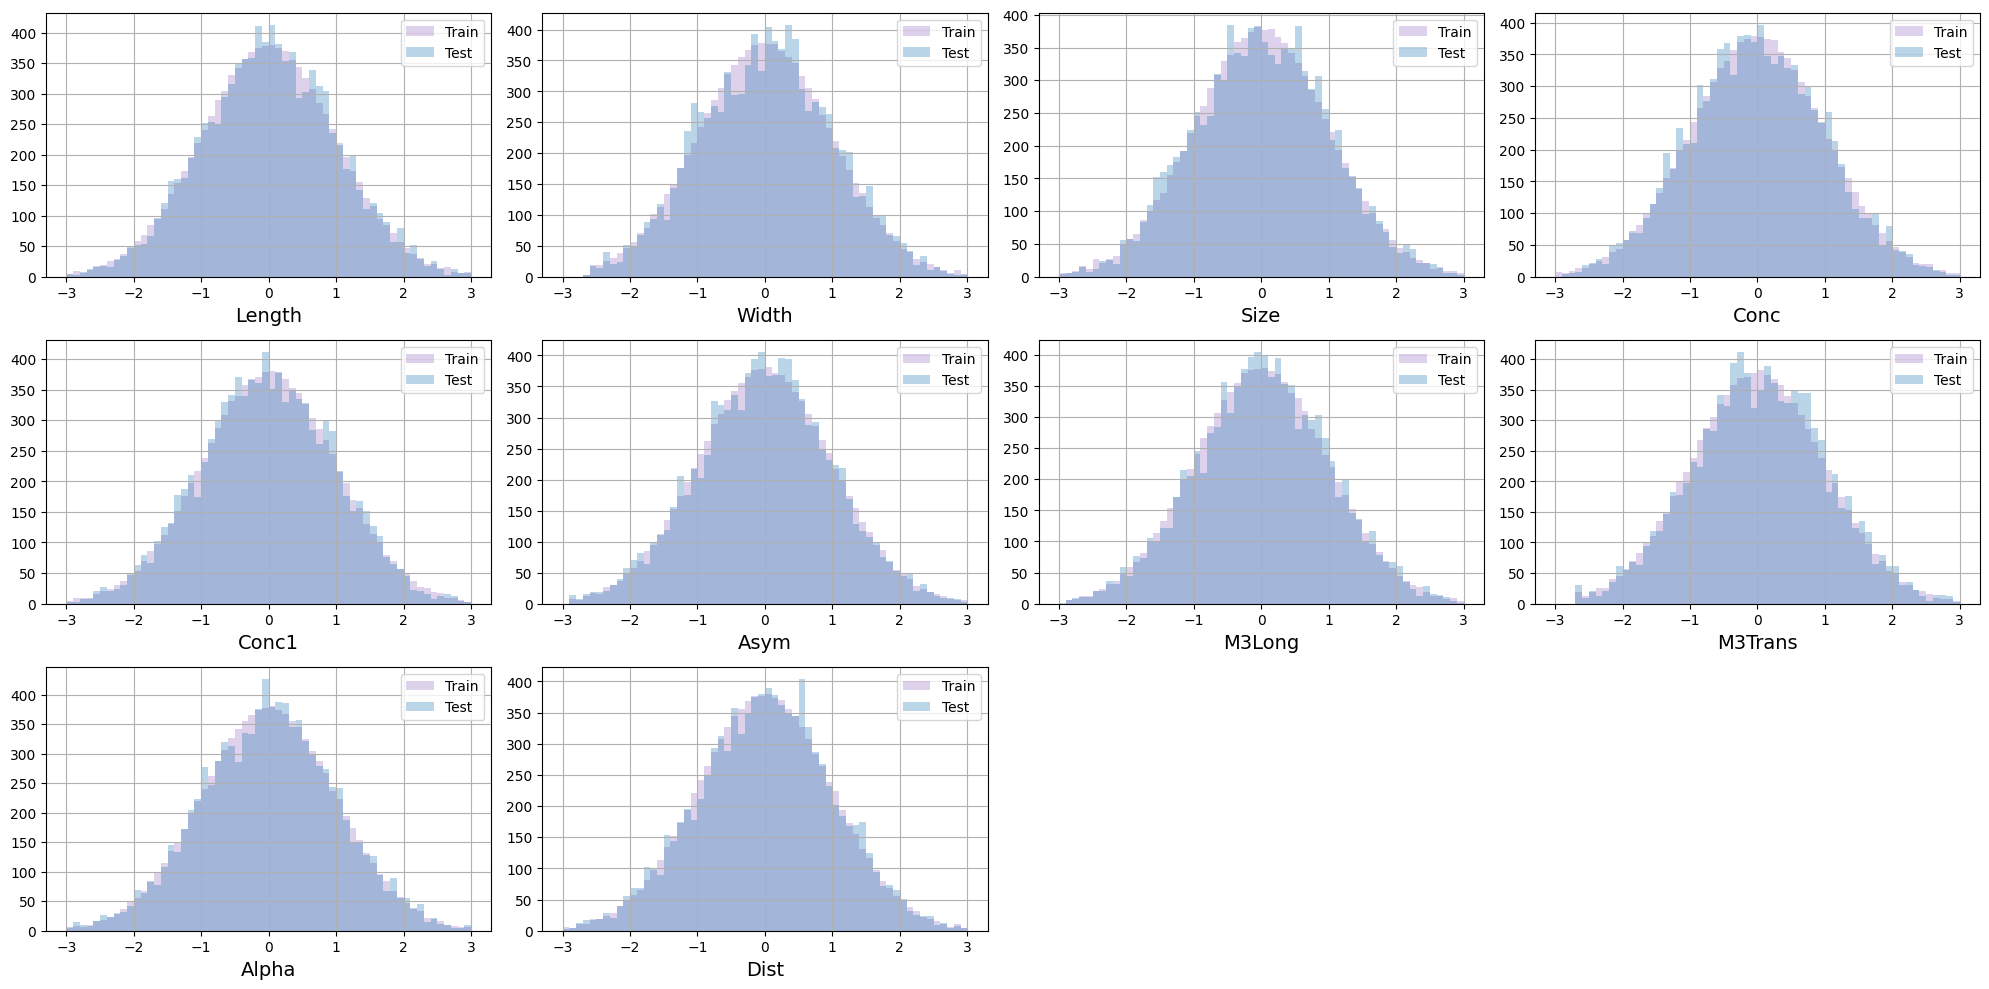

In [20]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Диффузионные модели (4 балла)

Проведем, по большому счету, такой же эксперимент, как в ДЗ-2, с диффузионной моделью.

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Задание 3 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [ ]:
def corrupt(x, amount):
   other_agent_score
    x = ...
    ### THE END OF YOUR CODE ###
    return x

In [22]:
def corrupt(x: torch.Tensor, amount: torch.Tensor) -> torch.Tensor:
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1)
    return x * (1 - amount) + noise * amount


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def other_agent_score(real_data, fake_data):
    X = np.vstack([real_data, fake_data])
    y = np.hstack([np.ones(len(real_data)), np.zeros(len(fake_data))])

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)
    y_pred_lr = lr_model.predict(X_test)
    lr_accuracy = accuracy_score(y_test, y_pred_lr)

    gb_model = GradientBoostingClassifier()
    gb_model.fit(X_train, y_train)
    y_pred_gb = gb_model.predict(X_test)
    gb_accuracy = accuracy_score(y_test, y_pred_gb)

    print(f"Logistic Regression Accuracy: {lr_accuracy}")
    print(f"Gradient Boosting Accuracy: {gb_accuracy}")
    
    return lr_accuracy, gb_accuracy


Добавим sсheduler, он пригодится вам при обучении модели.

*Советуем вниматиельно почитать доку по шедулеру.*

In [25]:
!pip install diffusers -q

In [26]:
from diffusers import DDPMScheduler

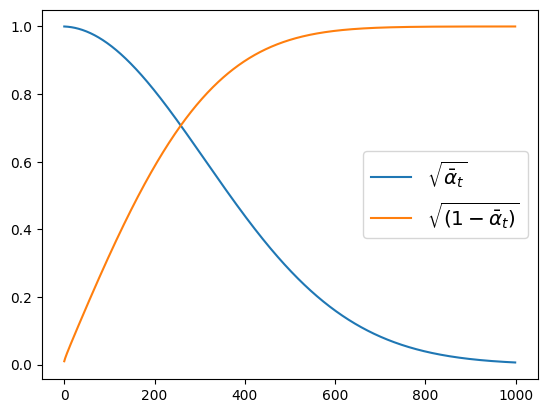

In [27]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")

## Задание 4 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?).

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [ ]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        ### YOUR CODE IS HERE ######

        ### THE END OF YOUR CODE ###

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return ...

In [30]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 100)
        self.bn1 = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, 100)
        self.bn2 = nn.BatchNorm1d(100)
        self.fc3 = nn.Linear(100, n_outputs)

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        x = F.relu(self.bn1(self.fc1(zy)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x


## Задание 5 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [ ]:
def generate_with_diffusion(model, y, latent_dim, sheduler):
    ### YOUR CODE IS HERE ######
    X_fake = ...
    ### THE END OF YOUR CODE ###
    return X_fake  # numpy

In [40]:
def generate_with_diffusion(model, y, latent_dim, scheduler):
    z = torch.randn((y.size(0), latent_dim)).to(DEVICE)
    model.eval()
    with torch.no_grad():
        X_fake = model(z, y).cpu().numpy()
    return X_fake


## Задание 6 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [ ]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        # Fit
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######

                ...

                loss_epoch += ...

                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch

            self.loss_history.append(loss_epoch)

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            ### YOUR CODE IS HERE ######
            ...
            ### THE END OF YOUR CODE ###

        # Turn off training
        self.model.train(False)

In [ ]:
class DiffusionFitter(object):
    def __init__(self, model, batch_size=32, n_epochs=10, latent_dim=1, lr=0.0001, n_critic=5):
        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic
        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)
        self.scheduler = DDPMScheduler(num_train_timesteps=1000)
        self.model.to(DEVICE)

    def fit(self, X, y):
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)
        dataset_real = TensorDataset(X_real, y_cond)
        self.model.train(True)
        self.loss_history = []

        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)):
                noisy_batch = corrupt(real_batch, amount=torch.tensor(0.1).to(DEVICE))
                gen_data = self.model(noisy_batch, cond_batch)
                loss = F.mse_loss(gen_data, real_batch)
                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()
                loss_epoch += loss.item()

            self.loss_history.append(loss_epoch / len(dataset_real))

            with torch.no_grad():
                X_fake_sample = generate_with_diffusion(self.model, y_cond[:1000], self.latent_dim, None)
                X_real_sample = X_real[:1000].cpu().numpy()
                lr_accuracy, gb_accuracy = other_agent_score(X_real_sample, X_fake_sample)
                print(f"Epoch {epoch+1}/{self.n_epochs}, Loss: {loss_epoch / len(dataset_real)}, "
                      f"LR Accuracy: {lr_accuracy}, GB Accuracy: {gb_accuracy}")

        self.model.train(False)


In [34]:
from diffusers import DDPMScheduler

class DiffusionFitter(object):
    def __init__(self, model, batch_size=32, n_epochs=10, latent_dim=1, lr=0.0001, n_critic=5):
        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic
        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)
        self.scheduler = DDPMScheduler(num_train_timesteps=1000)
        self.model.to(DEVICE)

    def fit(self, X, y):
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)
        dataset_real = TensorDataset(X_real, y_cond)
        self.model.train(True)
        self.loss_history = []

        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)):
                timestep = torch.randint(0, self.scheduler.num_train_timesteps, (real_batch.size(0),), device=DEVICE).long()
                noisy_batch = self.scheduler.add_noise(real_batch, torch.randn_like(real_batch), timestep)
                gen_data = self.model(noisy_batch, cond_batch)
                loss = F.mse_loss(gen_data, real_batch)
                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()
                
                loss_epoch += loss.item()

            self.loss_history.append(loss_epoch / len(dataset_real))
            
            with torch.no_grad():
                X_fake_sample = generate_with_diffusion(self.model, y_cond[:1000], self.latent_dim, self.scheduler)
                X_real_sample = X_real[:1000].cpu().numpy()
                lr_accuracy, gb_accuracy = other_agent_score(X_real_sample, X_fake_sample)
                print(f"Epoch {epoch+1}/{self.n_epochs}, Loss: {loss_epoch / len(dataset_real)}, "
                      f"LR Accuracy: {lr_accuracy}, GB Accuracy: {gb_accuracy}")

        self.model.train(False)


In [35]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.568
Gradient Boosting Accuracy: 0.912
Epoch 1/100, Loss: 0.016714242291876697, LR Accuracy: 0.568, GB Accuracy: 0.912


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.526
Gradient Boosting Accuracy: 0.902
Epoch 2/100, Loss: 0.01489253045381933, LR Accuracy: 0.526, GB Accuracy: 0.902


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.54
Gradient Boosting Accuracy: 0.904
Epoch 3/100, Loss: 0.014637934741663005, LR Accuracy: 0.54, GB Accuracy: 0.904


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.492
Gradient Boosting Accuracy: 0.916
Epoch 4/100, Loss: 0.014430648154264744, LR Accuracy: 0.492, GB Accuracy: 0.916


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.548
Gradient Boosting Accuracy: 0.9
Epoch 5/100, Loss: 0.014351283604539657, LR Accuracy: 0.548, GB Accuracy: 0.9


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.528
Gradient Boosting Accuracy: 0.906
Epoch 6/100, Loss: 0.014214031077083102, LR Accuracy: 0.528, GB Accuracy: 0.906


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.528
Gradient Boosting Accuracy: 0.896
Epoch 7/100, Loss: 0.01414151227749986, LR Accuracy: 0.528, GB Accuracy: 0.896


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.532
Gradient Boosting Accuracy: 0.916
Epoch 8/100, Loss: 0.014109381691765208, LR Accuracy: 0.532, GB Accuracy: 0.916


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.494
Gradient Boosting Accuracy: 0.914
Epoch 9/100, Loss: 0.014227868348642102, LR Accuracy: 0.494, GB Accuracy: 0.914


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.542
Gradient Boosting Accuracy: 0.922
Epoch 10/100, Loss: 0.014075013493764539, LR Accuracy: 0.542, GB Accuracy: 0.922


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.52
Gradient Boosting Accuracy: 0.906
Epoch 11/100, Loss: 0.013979950982814833, LR Accuracy: 0.52, GB Accuracy: 0.906


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.51
Gradient Boosting Accuracy: 0.914
Epoch 12/100, Loss: 0.013974291954256132, LR Accuracy: 0.51, GB Accuracy: 0.914


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.566
Gradient Boosting Accuracy: 0.922
Epoch 13/100, Loss: 0.013844595312069392, LR Accuracy: 0.566, GB Accuracy: 0.922


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.508
Gradient Boosting Accuracy: 0.924
Epoch 14/100, Loss: 0.014135212003871344, LR Accuracy: 0.508, GB Accuracy: 0.924


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.536
Gradient Boosting Accuracy: 0.918
Epoch 15/100, Loss: 0.014090675115585326, LR Accuracy: 0.536, GB Accuracy: 0.918


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.516
Gradient Boosting Accuracy: 0.922
Epoch 16/100, Loss: 0.013954433247243318, LR Accuracy: 0.516, GB Accuracy: 0.922


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.526
Gradient Boosting Accuracy: 0.904
Epoch 17/100, Loss: 0.014085160560913768, LR Accuracy: 0.526, GB Accuracy: 0.904


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.53
Gradient Boosting Accuracy: 0.906
Epoch 18/100, Loss: 0.014114501232479147, LR Accuracy: 0.53, GB Accuracy: 0.906


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.52
Gradient Boosting Accuracy: 0.916
Epoch 19/100, Loss: 0.013837780680440828, LR Accuracy: 0.52, GB Accuracy: 0.916


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.554
Gradient Boosting Accuracy: 0.926
Epoch 20/100, Loss: 0.013985502826427937, LR Accuracy: 0.554, GB Accuracy: 0.926


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.522
Gradient Boosting Accuracy: 0.932
Epoch 21/100, Loss: 0.014020560147509088, LR Accuracy: 0.522, GB Accuracy: 0.932


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.518
Gradient Boosting Accuracy: 0.928
Epoch 22/100, Loss: 0.013757578879751492, LR Accuracy: 0.518, GB Accuracy: 0.928


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.556
Gradient Boosting Accuracy: 0.92
Epoch 23/100, Loss: 0.013918978445913513, LR Accuracy: 0.556, GB Accuracy: 0.92


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.52
Gradient Boosting Accuracy: 0.92
Epoch 24/100, Loss: 0.013833339686273401, LR Accuracy: 0.52, GB Accuracy: 0.92


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.546
Gradient Boosting Accuracy: 0.918
Epoch 25/100, Loss: 0.013893317527575447, LR Accuracy: 0.546, GB Accuracy: 0.918


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.536
Gradient Boosting Accuracy: 0.902
Epoch 26/100, Loss: 0.014008476129967081, LR Accuracy: 0.536, GB Accuracy: 0.902


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.552
Gradient Boosting Accuracy: 0.914
Epoch 27/100, Loss: 0.013743606905455844, LR Accuracy: 0.552, GB Accuracy: 0.914


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.51
Gradient Boosting Accuracy: 0.924
Epoch 28/100, Loss: 0.01382842590693545, LR Accuracy: 0.51, GB Accuracy: 0.924


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.55
Gradient Boosting Accuracy: 0.904
Epoch 29/100, Loss: 0.013900945280001869, LR Accuracy: 0.55, GB Accuracy: 0.904


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.556
Gradient Boosting Accuracy: 0.93
Epoch 30/100, Loss: 0.013893383910603328, LR Accuracy: 0.556, GB Accuracy: 0.93


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.536
Gradient Boosting Accuracy: 0.952
Epoch 31/100, Loss: 0.013819646957544875, LR Accuracy: 0.536, GB Accuracy: 0.952


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.552
Gradient Boosting Accuracy: 0.936
Epoch 32/100, Loss: 0.013771909744832292, LR Accuracy: 0.552, GB Accuracy: 0.936


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.538
Gradient Boosting Accuracy: 0.91
Epoch 33/100, Loss: 0.013742278085396744, LR Accuracy: 0.538, GB Accuracy: 0.91


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.53
Gradient Boosting Accuracy: 0.912
Epoch 34/100, Loss: 0.013966473551578703, LR Accuracy: 0.53, GB Accuracy: 0.912


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.524
Gradient Boosting Accuracy: 0.912
Epoch 35/100, Loss: 0.013666437693198773, LR Accuracy: 0.524, GB Accuracy: 0.912


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.498
Gradient Boosting Accuracy: 0.922
Epoch 36/100, Loss: 0.013880725568464, LR Accuracy: 0.498, GB Accuracy: 0.922


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.558
Gradient Boosting Accuracy: 0.914
Epoch 37/100, Loss: 0.013850693588001119, LR Accuracy: 0.558, GB Accuracy: 0.914


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.528
Gradient Boosting Accuracy: 0.91
Epoch 38/100, Loss: 0.013812006635495415, LR Accuracy: 0.528, GB Accuracy: 0.91


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.54
Gradient Boosting Accuracy: 0.91
Epoch 39/100, Loss: 0.013870327126089831, LR Accuracy: 0.54, GB Accuracy: 0.91


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.524
Gradient Boosting Accuracy: 0.908
Epoch 40/100, Loss: 0.013839255249838724, LR Accuracy: 0.524, GB Accuracy: 0.908


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.534
Gradient Boosting Accuracy: 0.924
Epoch 41/100, Loss: 0.014072071860390632, LR Accuracy: 0.534, GB Accuracy: 0.924


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.558
Gradient Boosting Accuracy: 0.932
Epoch 42/100, Loss: 0.01385688105153486, LR Accuracy: 0.558, GB Accuracy: 0.932


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.602
Gradient Boosting Accuracy: 0.908
Epoch 43/100, Loss: 0.013690628655074649, LR Accuracy: 0.602, GB Accuracy: 0.908


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.548
Gradient Boosting Accuracy: 0.93
Epoch 44/100, Loss: 0.013870983322461446, LR Accuracy: 0.548, GB Accuracy: 0.93


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.538
Gradient Boosting Accuracy: 0.914
Epoch 45/100, Loss: 0.01387844323234478, LR Accuracy: 0.538, GB Accuracy: 0.914


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.544
Gradient Boosting Accuracy: 0.922
Epoch 46/100, Loss: 0.013526120424646685, LR Accuracy: 0.544, GB Accuracy: 0.922


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.56
Gradient Boosting Accuracy: 0.908
Epoch 47/100, Loss: 0.013643092321296596, LR Accuracy: 0.56, GB Accuracy: 0.908


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.574
Gradient Boosting Accuracy: 0.92
Epoch 48/100, Loss: 0.013791414976245347, LR Accuracy: 0.574, GB Accuracy: 0.92


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.534
Gradient Boosting Accuracy: 0.918
Epoch 49/100, Loss: 0.013690276129012604, LR Accuracy: 0.534, GB Accuracy: 0.918


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.55
Gradient Boosting Accuracy: 0.926
Epoch 50/100, Loss: 0.0139378963992172, LR Accuracy: 0.55, GB Accuracy: 0.926


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.536
Gradient Boosting Accuracy: 0.912
Epoch 51/100, Loss: 0.013640444402188283, LR Accuracy: 0.536, GB Accuracy: 0.912


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.538
Gradient Boosting Accuracy: 0.922
Epoch 52/100, Loss: 0.013980272051914508, LR Accuracy: 0.538, GB Accuracy: 0.922


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.57
Gradient Boosting Accuracy: 0.914
Epoch 53/100, Loss: 0.013811384252694629, LR Accuracy: 0.57, GB Accuracy: 0.914


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.498
Gradient Boosting Accuracy: 0.906
Epoch 54/100, Loss: 0.013973443835315643, LR Accuracy: 0.498, GB Accuracy: 0.906


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.56
Gradient Boosting Accuracy: 0.916
Epoch 55/100, Loss: 0.013620251805749727, LR Accuracy: 0.56, GB Accuracy: 0.916


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.542
Gradient Boosting Accuracy: 0.94
Epoch 56/100, Loss: 0.013773491706005782, LR Accuracy: 0.542, GB Accuracy: 0.94


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.548
Gradient Boosting Accuracy: 0.922
Epoch 57/100, Loss: 0.013806145436881594, LR Accuracy: 0.548, GB Accuracy: 0.922


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.524
Gradient Boosting Accuracy: 0.93
Epoch 58/100, Loss: 0.013782464166795669, LR Accuracy: 0.524, GB Accuracy: 0.93


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.546
Gradient Boosting Accuracy: 0.922
Epoch 59/100, Loss: 0.013665968549489725, LR Accuracy: 0.546, GB Accuracy: 0.922


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.544
Gradient Boosting Accuracy: 0.92
Epoch 60/100, Loss: 0.0136046443013112, LR Accuracy: 0.544, GB Accuracy: 0.92


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.61
Gradient Boosting Accuracy: 0.904
Epoch 61/100, Loss: 0.013762302350421307, LR Accuracy: 0.61, GB Accuracy: 0.904


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.534
Gradient Boosting Accuracy: 0.91
Epoch 62/100, Loss: 0.01367269097567858, LR Accuracy: 0.534, GB Accuracy: 0.91


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.488
Gradient Boosting Accuracy: 0.906
Epoch 63/100, Loss: 0.013691406981426082, LR Accuracy: 0.488, GB Accuracy: 0.906


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.59
Gradient Boosting Accuracy: 0.918
Epoch 64/100, Loss: 0.013591775912341009, LR Accuracy: 0.59, GB Accuracy: 0.918


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.54
Gradient Boosting Accuracy: 0.924
Epoch 65/100, Loss: 0.013754506266580896, LR Accuracy: 0.54, GB Accuracy: 0.924


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.582
Gradient Boosting Accuracy: 0.914
Epoch 66/100, Loss: 0.013662664104962073, LR Accuracy: 0.582, GB Accuracy: 0.914


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.534
Gradient Boosting Accuracy: 0.928
Epoch 67/100, Loss: 0.013792640293559567, LR Accuracy: 0.534, GB Accuracy: 0.928


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.6
Gradient Boosting Accuracy: 0.922
Epoch 68/100, Loss: 0.013962718054699222, LR Accuracy: 0.6, GB Accuracy: 0.922


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.518
Gradient Boosting Accuracy: 0.926
Epoch 69/100, Loss: 0.013716020685014414, LR Accuracy: 0.518, GB Accuracy: 0.926


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.53
Gradient Boosting Accuracy: 0.914
Epoch 70/100, Loss: 0.013690919975126328, LR Accuracy: 0.53, GB Accuracy: 0.914


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.562
Gradient Boosting Accuracy: 0.916
Epoch 71/100, Loss: 0.013720592505422928, LR Accuracy: 0.562, GB Accuracy: 0.916


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.544
Gradient Boosting Accuracy: 0.924
Epoch 72/100, Loss: 0.013603526397709089, LR Accuracy: 0.544, GB Accuracy: 0.924


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.57
Gradient Boosting Accuracy: 0.932
Epoch 73/100, Loss: 0.013662127562877885, LR Accuracy: 0.57, GB Accuracy: 0.932


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.538
Gradient Boosting Accuracy: 0.926
Epoch 74/100, Loss: 0.013830690269214498, LR Accuracy: 0.538, GB Accuracy: 0.926


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.526
Gradient Boosting Accuracy: 0.912
Epoch 75/100, Loss: 0.013514259347905622, LR Accuracy: 0.526, GB Accuracy: 0.912


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.534
Gradient Boosting Accuracy: 0.924
Epoch 76/100, Loss: 0.013621384184317884, LR Accuracy: 0.534, GB Accuracy: 0.924


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.51
Gradient Boosting Accuracy: 0.918
Epoch 77/100, Loss: 0.013827309708113926, LR Accuracy: 0.51, GB Accuracy: 0.918


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.504
Gradient Boosting Accuracy: 0.92
Epoch 78/100, Loss: 0.013947129412529721, LR Accuracy: 0.504, GB Accuracy: 0.92


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.522
Gradient Boosting Accuracy: 0.918
Epoch 79/100, Loss: 0.013628095798938682, LR Accuracy: 0.522, GB Accuracy: 0.918


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.562
Gradient Boosting Accuracy: 0.908
Epoch 80/100, Loss: 0.013584437041879328, LR Accuracy: 0.562, GB Accuracy: 0.908


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.544
Gradient Boosting Accuracy: 0.934
Epoch 81/100, Loss: 0.013737428642723213, LR Accuracy: 0.544, GB Accuracy: 0.934


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.536
Gradient Boosting Accuracy: 0.904
Epoch 82/100, Loss: 0.013610112751696012, LR Accuracy: 0.536, GB Accuracy: 0.904


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.514
Gradient Boosting Accuracy: 0.918
Epoch 83/100, Loss: 0.013516164195775735, LR Accuracy: 0.514, GB Accuracy: 0.918


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.526
Gradient Boosting Accuracy: 0.936
Epoch 84/100, Loss: 0.013858207643470804, LR Accuracy: 0.526, GB Accuracy: 0.936


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.522
Gradient Boosting Accuracy: 0.914
Epoch 85/100, Loss: 0.013508752069889433, LR Accuracy: 0.522, GB Accuracy: 0.914


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.508
Gradient Boosting Accuracy: 0.922
Epoch 86/100, Loss: 0.013683483336751519, LR Accuracy: 0.508, GB Accuracy: 0.922


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.51
Gradient Boosting Accuracy: 0.936
Epoch 87/100, Loss: 0.01385435900728284, LR Accuracy: 0.51, GB Accuracy: 0.936


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.532
Gradient Boosting Accuracy: 0.922
Epoch 88/100, Loss: 0.01361156075910815, LR Accuracy: 0.532, GB Accuracy: 0.922


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.556
Gradient Boosting Accuracy: 0.916
Epoch 89/100, Loss: 0.01370861148295217, LR Accuracy: 0.556, GB Accuracy: 0.916


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.58
Gradient Boosting Accuracy: 0.9
Epoch 90/100, Loss: 0.013787810468397933, LR Accuracy: 0.58, GB Accuracy: 0.9


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.54
Gradient Boosting Accuracy: 0.928
Epoch 91/100, Loss: 0.013426236455748886, LR Accuracy: 0.54, GB Accuracy: 0.928


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.556
Gradient Boosting Accuracy: 0.912
Epoch 92/100, Loss: 0.013571803567913428, LR Accuracy: 0.556, GB Accuracy: 0.912


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.58
Gradient Boosting Accuracy: 0.908
Epoch 93/100, Loss: 0.013452527842060373, LR Accuracy: 0.58, GB Accuracy: 0.908


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.556
Gradient Boosting Accuracy: 0.91
Epoch 94/100, Loss: 0.013745827764492055, LR Accuracy: 0.556, GB Accuracy: 0.91


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.568
Gradient Boosting Accuracy: 0.936
Epoch 95/100, Loss: 0.013702632949053929, LR Accuracy: 0.568, GB Accuracy: 0.936


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.576
Gradient Boosting Accuracy: 0.92
Epoch 96/100, Loss: 0.01380124165746065, LR Accuracy: 0.576, GB Accuracy: 0.92


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.53
Gradient Boosting Accuracy: 0.912
Epoch 97/100, Loss: 0.013752102087223442, LR Accuracy: 0.53, GB Accuracy: 0.912


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.548
Gradient Boosting Accuracy: 0.932
Epoch 98/100, Loss: 0.01372663752263026, LR Accuracy: 0.548, GB Accuracy: 0.932


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.546
Gradient Boosting Accuracy: 0.928
Epoch 99/100, Loss: 0.013937861363469113, LR Accuracy: 0.546, GB Accuracy: 0.928


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Logistic Regression Accuracy: 0.556
Gradient Boosting Accuracy: 0.918
Epoch 100/100, Loss: 0.013693145136853248, LR Accuracy: 0.556, GB Accuracy: 0.918
CPU times: user 2min 5s, sys: 26.7 s, total: 2min 31s
Wall time: 1min 50s


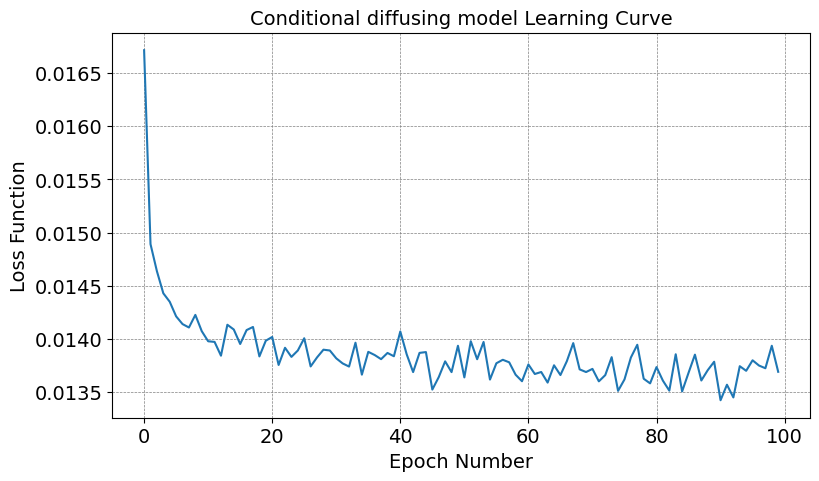

In [37]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(visible=True, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 7 (0.5 балла)
По аналогии с прошлым экспериментом (из ДЗ-2) с GAN моделью сгенерируйте выборку фейковых объектов, равную размеру тестовой выборки, и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с сWGAN моделью?

In [41]:
X_fake = generate_with_diffusion(diffusionFitter.model, y_test, latent_dim, diffusionFitter.scheduler)

TypeError: 'int' object is not callable

In [48]:
y.shape

AttributeError: 'tuple' object has no attribute 'size'

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

X_combined = np.vstack([X_test, X_fake])
y_combined = np.hstack([np.ones(X_test.shape[0]), np.zeros(X_fake.shape[0])])

clf = GradientBoostingClassifier()
clf.fit(X_combined, y_combined)

y_pred = clf.predict(X_combined)
y_proba = clf.predict_proba(X_combined)[:, 1]
roc_auc = roc_auc_score(y_combined, y_proba)
accuracy = accuracy_score(y_combined, y_pred)

print(f"ROC-AUC: {roc_auc}, Accuracy: {accuracy}")


# Потоки (4 балла)

## Задание 8 (1.5 балла)

Диффузия показала себя как достойный конкурент GAN модели. Так как данных не много, обучали не долго, задача не сложная - отличия от GAN не так заметны, но все равно достойные.

Для Diffusion получили ROC AUC около 0.73 (меньше лучше). Попробуем обучить RealNVP для решения этой задачи.

**Дополните базовый класс для нормализационного необходимым.**

<center><img src="img/mem1.jpg" width="500"></center>

<center><img src="img/mem2.jpg" width="500"></center>

In [ ]:
trainloader = torch.utils.data.DataLoader(X_train, batch_size=64, shuffle=True)

In [ ]:
# Main class for NormFlow
class NormalizingFlow(nn.Module):

    def __init__(self, layers, prior):
        super(NormalizingFlow, self).__init__()

        # your code below

    def log_prob(self, x):
        log_likelihood = None

        for layer in self.layers:
            x, change = layer.f(x)
            if log_likelihood is not None:
                log_likelihood = # your code here
            else:
                log_likelihood = # your code here

        log_likelihood = # your code here

        return log_likelihood.mean()

    def sample(self, num_samples):
        x = self.prior.sample((num_samples, ))

        for layer in self.layers[::-1]:
            x = layer.g(x)

        return x

## Задание 9 (2 балла)

Реализуйте нейронную сеть RealNVP. Возьмите для прямого и обратного преобразования нейронную сеть (функцию) со следующими параметрами:

- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

In [ ]:
import torch.nn as nn

class RealNVP(nn.Module):
    def __init__(self, var_size, mask, hidden=100):
        super(RealNVP, self).__init__()
        self.mask = mask  # вам это может не понадобиться. Восприниматйте как подсказку
        self.var_size = var_size

        self.nn_t = # your code here
        self.nn_s = # your code here

    def f(self, x):
        t = # your code here
        s = # your code here

        new_x = # your code here

        log_det = # your code here
        return new_x, log_det

    def g(self, x):
        t = # your code here
        s = # your code here

        new_x = # your code here
        return new_x

In [ ]:
def train_nf(tr_dataloader, nf, opt, num_epochs):
    nf.train()
    loss_trace = []

    iter_i = 0

    for epoch_i in range(num_epochs):
        print(f'Epoch {epoch_i + 1}')
        for batch in tr_dataloader:

            x = batch.float()

            opt.zero_grad()

            loss = # your code here
            loss.backward()

            opt.step()

            loss_trace.append((iter_i, loss.item()))

            iter_i += 1

In [ ]:
prior = torch.distributions.MultivariateNormal(torch.zeros(10), torch.eye(10))

layers = []
for i in range(4):
    layers.append(RealNVP(var_size=10, mask=((torch.arange(10) + i) % 2)))

nf = NormalizingFlow(layers=layers,
                    prior=prior)

opt = torch.optim.Adam(nf.parameters(), lr=1e-3)

In [ ]:
train_nf(trainloader, nf, opt, num_epochs=10)

## Задание 10 (0.5 балла)

По аналогии с прошлым экспериментом с диффузией сгенерируйте выборку фейковых объектов, равную размеру тестовой выборки, и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с остальными моделями?

# Улучшения (1+ балл)

Попробуйте настроить параметры обучения какой-нибудь модели или еще как-нибудь их улучшить, чтобы получить как можно меньший ROC AUC. Что получилось? Какая модель лучше?

Ставим 0.1 балл за каждую сотую скора сверх (сниз) ROC-AUC=0.65 невключительно. Т.е. за 0.65 получаете 0, за 0.649 -- 0.1, 0.639 -- 0.2, 0.609 -- 0.5, 0.559 -- 1

In [ ]:
# your code here


# (*) Аналитика (1 балл)

***Убедительно* подвтердите или опровергните гипотезу "Синтетические данные НЕ помогают лучше классифицировать частицы из исходного датасета."**

Здесь от вас ожидается что-то в духе аналитической записки. Приветствуются графики и прочие "умные вещи". На максимальный балл это весьма объемное задание.